In [59]:
%pylab inline
import xcml
import siestah2o as h2o
import pickle
from mbpol_calculator import MbpolCalculator, reconnect_monomers
from ase import Atoms
import siesta_utils.grid as siesta
from ase.io import iread

Populating the interactive namespace from numpy and matplotlib


In [33]:
feat_getter = h2o.DescriptorGetter()

In [34]:
coords = xcml.find_coords('../test_run_2/siesta/H2O.out')

In [35]:
forces_siesta = xcml.find_forces('../test_run_2/siesta/H2O.out')

In [36]:
features = feat_getter.get_features(coords)

In [37]:
siesta.get_data_bin('H2O.RHOXC');

In [38]:
siesta.grid

array([144, 144, 144,   1])

In [140]:
krr_O = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Oxygen_descr', 'rb'))
krr_H = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Hydrogen_descr', 'rb'))
krr_O_dx = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_dx_O_descriptors', 'rb'))
krr_H_dx = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_dx_H_descriptors', 'rb'))
nn = xcml.load_network('/gpfs/home/smdick/exchange_ml/models/final/nn_mulliken_descriptors_dz/')

INFO:tensorflow:Restoring parameters from /gpfs/home/smdick/exchange_ml/models/final/nn_mulliken_descriptors_dz/model.ckpt


In [40]:
atoms = Atoms('128H2O')

atoms.set_positions(coords.reshape(-1,3))
atoms.set_pbc(True)
atoms.set_cell([15.646,15.646,15.646])

atoms = reconnect_monomers(atoms)

atoms.set_calculator(MbpolCalculator(atoms))

atoms.get_forces()

array([[-0.93323886,  0.17880791,  2.13645148],
       [ 0.36085493,  0.93228351, -0.21809922],
       [ 0.66792577, -1.15250819, -1.95545024],
       ...,
       [-0.3583705 , -1.41472626, -0.26388346],
       [ 0.45236685,  2.46476291, -0.13324978],
       [-0.10034983, -0.51363785,  0.45145615]])

In [41]:
coords = xcml.fold_back_coords(coords, siesta)

force_corr = xcml.use_force_model(features[0].reshape(-1,34), krr_O, krr_H, 18,8, glob_cs = True, coords = coords).reshape(-1,3)
force_corr_dz = xcml.use_force_model_fd(features[0].reshape(-1,34), krr_O_dx, krr_H_dx,nn, 18,8, glob_cs = True, coords=coords, direction_factor = 1e4 )

Sharing scaler with species O
Sharing scaler with species H
Sharing scaler with species O
Sharing scaler with species H


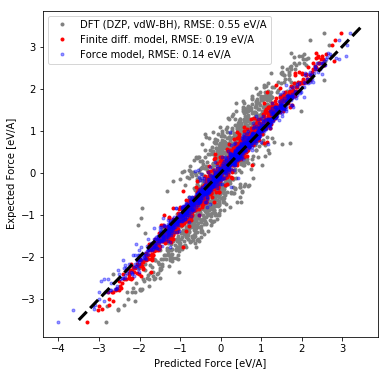

In [44]:
figsize(6,6)
rms_siesta = np.sqrt(np.mean((forces_siesta - atoms.get_forces())**2))
rms_corr_dz = np.sqrt(np.mean((forces_siesta- force_corr_dz.reshape(-1,3) - atoms.get_forces())**2))
rms_corr = np.sqrt(np.mean((forces_siesta  - force_corr -atoms.get_forces())**2))

plot(forces_siesta.flatten(), atoms.get_forces().flatten(), ls = '', marker = '.', color = 'grey',
    label = 'DFT (DZP, vdW-BH), RMSE: {:.2f} eV/A'.format(rms_siesta))
plot((forces_siesta - force_corr_dz.reshape(-1,3)).flatten(), atoms.get_forces().flatten(), ls = '', marker = '.', 
     color = 'red', label = 'Finite diff. model, RMSE: {:.2f} eV/A'.format(rms_corr_dz))
plot((forces_siesta - force_corr).flatten(), atoms.get_forces().flatten(),
     ls = '', marker = '.', color = 'blue', alpha = 0.4,
    label = 'Force model, RMSE: {:.2f} eV/A'.format(rms_corr))
plot([-3.5,3.5],[-3.5,3.5], color = 'black', ls ='--', lw = 3.1)
legend()
xlabel('Predicted Force [eV/A]')
ylabel('Expected Force [eV/A]')
savefig('force_128.pdf')
savefig('force_128.eps')

In [74]:
all_features = np.genfromtxt('/gpfs/home/smdick/md_routines/test_run/siesta/features.dat', delimiter = ',').reshape(-1,128,34)

all_features = all_features[::5]

In [111]:
all_traj = iread('/gpfs/home/smdick/md_routines/test_run/md_siesta_10.traj')

In [77]:
import pandas as pd

In [131]:
all_energies = pd.read_csv('/gpfs/home/smdick/md_routines/test_run/siesta/energies.dat', delim_whitespace=True)[:-1]
all_energies.head()

,Siesta,Corrected
0,-19.8212,-43.8297
1,-20.3071,-44.6790
2,-21.7612,-47.2137
3,-23.4140,-50.6246
4,-24.1785,-53.7271


In [112]:
atoms = Atoms('128H2O')

atoms.set_positions(coords.reshape(-1,3))
atoms.set_pbc(True)
atoms.set_cell([15.646,15.646,15.646])

atoms = reconnect_monomers(atoms)

atoms.set_calculator(MbpolCalculator(atoms))

i = 0
mbpol_energies = []
for traj in all_traj:
    atoms.set_positions(traj.get_positions())
    atoms = reconnect_monomers(atoms)
    mbpol_energies.append(atoms.get_potential_energy())
    if i%100 == 0:
        print(i)
    i+=1

0
100
200
300
400
500
600


In [122]:
len(mbpol_energies[::5])

123

In [121]:
len(all_energies)

123

In [118]:
mbpol_energies.append(all_energies.iloc[-1,1])

In [132]:
all_energies['Mbpol'] = mbpol_energies[:-1]

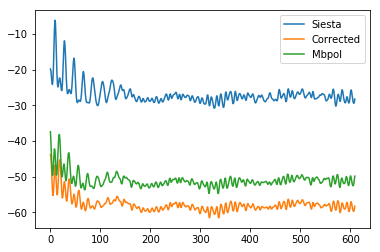

In [133]:
all_energies.plot()
legend()

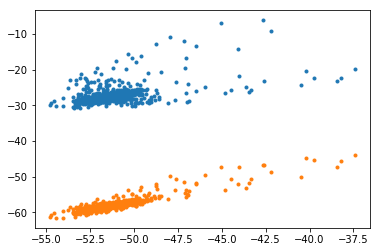

In [134]:
plot(all_energies['Mbpol'], all_energies['Siesta'], ls = '', marker ='.')
plot(all_energies['Mbpol'], all_energies['Corrected'], ls = '', marker ='.')

In [135]:
np.std(all_energies['Mbpol'] - all_energies['Siesta'])/128

0.019825639534326242

In [136]:
np.std(all_energies['Mbpol'] - all_energies['Corrected'])/128

0.0066856973076541

In [101]:
correction = all_energies['Corrected'] - all_energies['Siesta'] 

In [104]:
correction_from_model = xcml.use_model_descr(all_features, 128,nn)

Sharing scaler with species O
Sharing scaler with species H


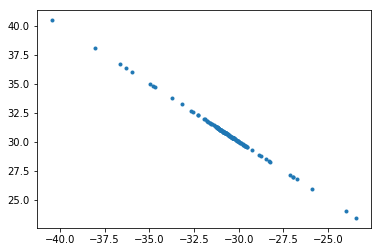

In [106]:
plot(correction, correction_from_model, ls = '', marker = '.')

In [138]:
all_energies

,Siesta,Corrected,Mbpol
0,-19.8212,-43.8297,-37.421572
1,-20.3071,-44.6790,-40.222781
2,-21.7612,-47.2137,-44.027002
3,-23.4140,-50.6246,-47.594535
4,-24.1785,-53.7271,-49.656018
5,-23.0208,-55.3066,-49.411463
6,-19.4954,-54.6321,-47.087794
7,-14.2458,-51.9712,-44.078999
8,-9.0626,-48.7223,-42.223490
9,-6.1454,-46.7702,-42.663719
